In [1]:
#from google.colab import files
#uploaded = files.upload()

ModuleNotFoundError: No module named 'google.colab'

In [2]:
#! mkdir ~/.kaggle

In [3]:
#! cp kaggle.json ~/.kaggle/

In [4]:
#! chmod 600 ~/.kaggle/kaggle.json

In [7]:
#! kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k

100%|█████████████████████████████████████▉| 1.62G/1.62G [09:09<00:00, 3.22MB/s]
100%|██████████████████████████████████████| 1.62G/1.62G [09:09<00:00, 3.17MB/s]


In [8]:
#! mkdir ocular-disease

In [13]:
#! unzip ocular-disease-recognition-odir5k.zip -d ocular-disease

Archive:  ocular-disease-recognition-odir5k.zip
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/1000_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/1000_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/1001_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/1001_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/1002_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/1002_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/1003_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/1003_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/1004_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/1004_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/1007_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/1007_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Te

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/1305_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/1312_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/1312_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/1315_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/1315_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/1317_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/1317_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/1321_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/1321_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/1322_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/1322_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/1323_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/1323_right.jpg  
  inflating: ocula

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/1499_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/1499_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/1500_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/1500_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/1501_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/1501_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/1502_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/1502_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/1508_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/1508_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/1511_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/1511_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/1512_left.jpg  
  inflating: ocular

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/1922_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/1922_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/1926_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/1926_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/1931_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/1931_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/1960_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/1960_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/1966_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/1966_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/1972_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/1972_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/1979_left.jpg  
  inflating: ocular

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/3452_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/3452_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/3453_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/3453_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/3454_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/3454_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/3455_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/3455_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/3456_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/3456_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/3457_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/3457_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/3458_left.jpg  
  inflating: ocular

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/3508_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/3508_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/3509_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/3509_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/3510_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/3510_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/3511_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/3511_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/3512_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/3512_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/3513_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/3513_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/3514_left.jpg  
  inflating: ocular

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/3562_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/3563_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/3563_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/3564_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/3564_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/3565_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/3565_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/3566_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/3566_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/3567_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/3567_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/3568_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/3568_right.jpg  
  inflating: ocula

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/4145_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/4145_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/4228_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/4228_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/4423_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/4423_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/4434_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/4434_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/4482_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/4482_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/4503_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/4503_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/4510_left.jpg  
  inflating: ocular

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/4729_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/4729_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/4730_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/4730_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/4731_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/4731_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/4732_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/4732_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/4733_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/4733_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/4734_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/4734_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/4735_left.jpg  
  inflating: ocular

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/995_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Testing Images/995_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/0_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/0_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1005_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1005_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1006_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1006_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1008_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1008_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/100_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/100_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1010_left.jpg  
  inflating: ocula

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/106_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/106_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1071_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1071_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1072_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1072_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1074_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1074_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1075_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1075_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1077_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1077_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1079_left.jpg  
  inflat

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/113_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1140_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1140_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1142_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1142_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1143_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1143_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1144_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1144_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1145_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1145_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1146_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1146_right.jpg  
  infl

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1216_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1216_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1217_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1217_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1218_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1218_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1219_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1219_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/121_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/121_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1220_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1220_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1221_left.jpg  
  inflat

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/127_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1280_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1280_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1281_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1281_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1282_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1282_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1284_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1284_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1285_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1285_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1286_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1286_right.jpg  
  infl

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/136_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/136_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1371_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1371_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1373_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1373_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1374_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1374_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1377_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1377_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1378_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1378_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/137_left.jpg  
  inflati

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1444_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1444_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1447_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1447_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/144_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/144_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1450_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1450_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1452_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1452_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1453_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1453_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1454_left.jpg  
  inflat

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/151_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1520_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1520_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1523_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1523_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1526_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1526_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1527_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1527_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1528_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1528_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1529_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1529_right.jpg  
  infl

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1578_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1579_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1579_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/157_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/157_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1580_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1580_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1581_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1581_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1583_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1583_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1584_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1584_right.jpg  
  infla

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1647_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/164_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/164_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1652_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1652_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1657_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1657_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1659_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1659_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/165_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/165_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1660_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1660_right.jpg  
  inflati

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/183_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/183_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1840_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1840_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1841_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1841_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1843_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1843_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1844_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1844_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1845_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1845_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1846_left.jpg  
  inflat

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1964_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1965_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1965_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1967_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1967_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1968_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1968_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/196_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/196_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1970_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1970_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1971_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/1971_right.jpg  
  infla

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2101_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2102_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2102_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2103_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2103_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2104_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2104_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2105_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2105_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2106_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2106_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2107_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2107_right.jpg  
  inf

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2154_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2154_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2155_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2155_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2156_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2156_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2157_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2157_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2158_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2158_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2159_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2159_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/215_left.jpg  
  infla

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2206_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2206_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2207_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2207_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2208_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2208_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2209_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2209_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/220_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/220_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2210_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2210_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2211_left.jpg  
  inflat

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/232_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/232_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2330_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2330_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2331_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2331_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2332_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2332_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2333_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2333_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2334_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2334_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2335_left.jpg  
  inflat

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2380_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2381_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2381_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2382_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2382_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2383_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2383_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2384_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2384_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2385_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2385_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2386_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2386_right.jpg  
  inf

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2429_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/242_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/242_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2430_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2430_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2431_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2431_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2432_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2432_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2433_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2433_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2434_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2434_right.jpg  
  infla

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2478_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2478_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2479_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2479_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/247_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/247_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2480_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2480_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2481_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2481_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2482_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2482_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2483_left.jpg  
  inflat

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/252_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2530_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2530_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2531_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2531_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2532_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2532_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2533_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2533_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2534_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2534_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2535_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2535_right.jpg  
  infl

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2580_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2580_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2581_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2581_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2582_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2582_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2583_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2583_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2584_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2584_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2585_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2585_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2586_left.jpg  
  infl

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2630_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2631_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2631_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2632_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2632_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2633_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2633_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2634_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2634_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2635_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2635_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2636_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2636_right.jpg  
  inf

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2682_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2682_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2683_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2683_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2684_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2684_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2685_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2685_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2686_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2686_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2687_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2687_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2688_left.jpg  
  infl

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2732_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2733_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2733_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2734_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2734_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2735_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2735_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2736_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2736_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2737_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2737_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2738_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2738_right.jpg  
  inf

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2783_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2783_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2784_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2784_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2785_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2785_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2786_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2786_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2787_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2787_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2788_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2788_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2789_left.jpg  
  infl

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2830_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2831_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2831_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2832_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2832_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2833_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2833_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2834_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2834_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2835_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2835_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2836_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2836_right.jpg  
  inf

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/287_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2880_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2880_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2881_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2881_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2882_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2882_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2883_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2883_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2884_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2884_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2885_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2885_right.jpg  
  infl

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2928_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2929_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2929_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/292_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/292_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2930_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2930_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2931_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2931_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2932_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2932_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2933_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2933_right.jpg  
  infla

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2980_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2981_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2981_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2982_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2982_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2983_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2983_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2984_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2984_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2985_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2985_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2986_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/2986_right.jpg  
  inf

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3029_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3029_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/302_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/302_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3030_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3030_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3031_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3031_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3032_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3032_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3033_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3033_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3034_left.jpg  
  inflat

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3078_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3079_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3079_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/307_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/307_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3080_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3080_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3081_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3081_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3082_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3082_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3083_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3083_right.jpg  
  infla

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3129_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3129_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/312_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/312_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3130_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3130_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3131_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3131_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3132_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3132_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3133_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3133_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3134_left.jpg  
  inflat

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/317_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/317_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3180_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3180_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3181_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3181_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3182_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3182_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3183_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3183_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3184_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3184_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3185_left.jpg  
  inflat

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3228_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3229_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3229_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/322_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/322_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3230_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3230_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3231_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3231_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3232_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3232_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3233_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3233_right.jpg  
  infla

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3280_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3280_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3281_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3281_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3282_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3282_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3283_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3283_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3284_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3284_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3285_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3285_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3286_left.jpg  
  infl

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3328_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3329_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3329_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/332_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/332_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3330_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3330_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3331_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3331_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3332_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3332_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3333_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3333_right.jpg  
  infla

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/337_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3380_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3380_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3381_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3381_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3382_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3382_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3383_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3383_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3384_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3384_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3385_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3385_right.jpg  
  infl

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3429_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3429_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/342_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/342_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3430_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3430_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3431_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3431_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3432_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3432_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3433_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3433_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3434_left.jpg  
  inflat

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/373_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/373_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/374_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/374_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/375_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/375_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/376_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/376_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/377_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/377_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/378_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/378_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/379_left.jpg  
  inflating: ocular

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3969_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3969_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/396_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/396_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3970_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3970_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3971_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3971_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3972_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3972_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3973_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3973_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/3976_left.jpg  
  inflat

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4025_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4026_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4026_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4027_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4027_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4028_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4028_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4029_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4029_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/402_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/402_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4030_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4030_right.jpg  
  infla

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/407_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4080_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4080_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4081_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4081_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4082_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4082_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4083_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4083_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4084_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4084_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4085_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4085_right.jpg  
  infl

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4131_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4133_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4133_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4134_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4134_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4136_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4136_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4137_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4137_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4138_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4138_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4139_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4139_right.jpg  
  inf

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4191_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4191_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4192_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4192_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4193_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4193_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4194_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4194_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4195_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4195_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4196_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4196_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4197_left.jpg  
  infl

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4244_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4244_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4245_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4245_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4246_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4246_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4247_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4247_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4248_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4248_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4249_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4249_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/424_left.jpg  
  infla

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/429_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/429_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/42_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/42_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4300_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4300_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4301_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4301_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4302_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4302_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4303_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4303_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4304_left.jpg  
  inflating:

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/434_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/434_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4350_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4350_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4351_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4351_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4352_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4352_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4353_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4353_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4354_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4354_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4355_left.jpg  
  inflat

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4409_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/440_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/440_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4410_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4410_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4411_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4411_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4412_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4412_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4413_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4413_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4414_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4414_right.jpg  
  infla

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4464_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4464_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4465_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4465_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4466_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4466_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4467_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4467_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4468_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4468_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4469_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4469_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/446_left.jpg  
  infla

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4527_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4528_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4528_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4529_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4529_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/452_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/452_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4530_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4530_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4531_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4531_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4532_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4532_right.jpg  
  infla

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4579_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/457_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/457_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4580_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4580_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4581_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4581_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4582_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4582_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4583_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4583_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4584_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4584_right.jpg  
  infla

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4631_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4632_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4632_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4633_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4633_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4634_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4634_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4635_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4635_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4636_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4636_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4637_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4637_right.jpg  
  inf

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/476_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/477_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/477_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4784_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/4784_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/478_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/478_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/479_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/479_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/47_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/47_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/480_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/480_right.jpg  
  inflating: ocula

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/526_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/526_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/527_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/527_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/528_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/528_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/529_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/529_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/52_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/52_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/530_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/530_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/531_left.jpg  
  inflating: ocular-d

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/578_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/579_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/579_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/57_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/57_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/580_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/580_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/581_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/581_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/582_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/582_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/583_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/583_right.jpg  
  inflating: ocular-

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/630_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/631_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/631_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/632_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/632_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/633_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/633_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/634_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/634_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/635_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/635_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/636_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/636_right.jpg  
  inflating: ocula

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/684_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/684_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/685_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/685_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/686_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/686_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/687_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/687_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/688_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/688_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/689_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/689_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/68_left.jpg  
  inflating: ocular-

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/733_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/734_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/734_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/735_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/735_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/736_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/736_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/737_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/737_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/738_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/738_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/739_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/739_right.jpg  
  inflating: ocula

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/786_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/787_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/787_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/788_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/788_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/789_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/789_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/78_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/78_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/790_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/790_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/791_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/791_right.jpg  
  inflating: ocular-

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/838_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/838_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/839_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/839_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/83_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/83_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/840_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/840_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/841_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/841_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/842_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/842_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/843_left.jpg  
  inflating: ocular-d

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/887_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/888_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/888_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/889_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/889_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/88_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/88_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/890_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/890_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/891_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/891_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/892_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/892_right.jpg  
  inflating: ocular-

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/936_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/938_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/938_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/939_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/939_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/93_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/93_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/940_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/940_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/941_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/941_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/942_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/942_right.jpg  
  inflating: ocular-

  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/98_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/990_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/990_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/991_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/991_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/992_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/992_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/993_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/993_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/994_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/994_right.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/996_left.jpg  
  inflating: ocular-disease/ODIR-5K/ODIR-5K/Training Images/996_right.jpg  
  inflating: ocular

  inflating: ocular-disease/preprocessed_images/1085_left.jpg  
  inflating: ocular-disease/preprocessed_images/1085_right.jpg  
  inflating: ocular-disease/preprocessed_images/1086_left.jpg  
  inflating: ocular-disease/preprocessed_images/1086_right.jpg  
  inflating: ocular-disease/preprocessed_images/1089_left.jpg  
  inflating: ocular-disease/preprocessed_images/108_right.jpg  
  inflating: ocular-disease/preprocessed_images/1090_left.jpg  
  inflating: ocular-disease/preprocessed_images/1090_right.jpg  
  inflating: ocular-disease/preprocessed_images/1091_left.jpg  
  inflating: ocular-disease/preprocessed_images/1091_right.jpg  
  inflating: ocular-disease/preprocessed_images/1092_left.jpg  
  inflating: ocular-disease/preprocessed_images/1092_right.jpg  
  inflating: ocular-disease/preprocessed_images/1093_left.jpg  
  inflating: ocular-disease/preprocessed_images/1093_right.jpg  
  inflating: ocular-disease/preprocessed_images/1094_left.jpg  
  inflating: ocular-disease/prepro

  inflating: ocular-disease/preprocessed_images/1202_left.jpg  
  inflating: ocular-disease/preprocessed_images/1202_right.jpg  
  inflating: ocular-disease/preprocessed_images/1205_left.jpg  
  inflating: ocular-disease/preprocessed_images/1205_right.jpg  
  inflating: ocular-disease/preprocessed_images/1206_left.jpg  
  inflating: ocular-disease/preprocessed_images/1206_right.jpg  
  inflating: ocular-disease/preprocessed_images/1207_left.jpg  
  inflating: ocular-disease/preprocessed_images/1207_right.jpg  
  inflating: ocular-disease/preprocessed_images/1209_left.jpg  
  inflating: ocular-disease/preprocessed_images/1209_right.jpg  
  inflating: ocular-disease/preprocessed_images/120_left.jpg  
  inflating: ocular-disease/preprocessed_images/120_right.jpg  
  inflating: ocular-disease/preprocessed_images/1210_left.jpg  
  inflating: ocular-disease/preprocessed_images/1210_right.jpg  
  inflating: ocular-disease/preprocessed_images/1211_left.jpg  
  inflating: ocular-disease/preproc

  inflating: ocular-disease/preprocessed_images/1280_left.jpg  
  inflating: ocular-disease/preprocessed_images/1280_right.jpg  
  inflating: ocular-disease/preprocessed_images/1281_left.jpg  
  inflating: ocular-disease/preprocessed_images/1281_right.jpg  
  inflating: ocular-disease/preprocessed_images/1282_left.jpg  
  inflating: ocular-disease/preprocessed_images/1282_right.jpg  
  inflating: ocular-disease/preprocessed_images/1284_left.jpg  
  inflating: ocular-disease/preprocessed_images/1284_right.jpg  
  inflating: ocular-disease/preprocessed_images/1285_left.jpg  
  inflating: ocular-disease/preprocessed_images/1285_right.jpg  
  inflating: ocular-disease/preprocessed_images/1286_left.jpg  
  inflating: ocular-disease/preprocessed_images/1286_right.jpg  
  inflating: ocular-disease/preprocessed_images/1287_left.jpg  
  inflating: ocular-disease/preprocessed_images/1287_right.jpg  
  inflating: ocular-disease/preprocessed_images/1288_left.jpg  
  inflating: ocular-disease/prepr

  inflating: ocular-disease/preprocessed_images/139_right.jpg  
  inflating: ocular-disease/preprocessed_images/13_left.jpg  
  inflating: ocular-disease/preprocessed_images/13_right.jpg  
  inflating: ocular-disease/preprocessed_images/1402_left.jpg  
  inflating: ocular-disease/preprocessed_images/1402_right.jpg  
  inflating: ocular-disease/preprocessed_images/1404_left.jpg  
  inflating: ocular-disease/preprocessed_images/1404_right.jpg  
  inflating: ocular-disease/preprocessed_images/1405_left.jpg  
  inflating: ocular-disease/preprocessed_images/1405_right.jpg  
  inflating: ocular-disease/preprocessed_images/1406_left.jpg  
  inflating: ocular-disease/preprocessed_images/1406_right.jpg  
  inflating: ocular-disease/preprocessed_images/1408_left.jpg  
  inflating: ocular-disease/preprocessed_images/1408_right.jpg  
  inflating: ocular-disease/preprocessed_images/1409_left.jpg  
  inflating: ocular-disease/preprocessed_images/1409_right.jpg  
  inflating: ocular-disease/preproces

  inflating: ocular-disease/preprocessed_images/1480_left.jpg  
  inflating: ocular-disease/preprocessed_images/1480_right.jpg  
  inflating: ocular-disease/preprocessed_images/1482_left.jpg  
  inflating: ocular-disease/preprocessed_images/1482_right.jpg  
  inflating: ocular-disease/preprocessed_images/1483_left.jpg  
  inflating: ocular-disease/preprocessed_images/1483_right.jpg  
  inflating: ocular-disease/preprocessed_images/1484_left.jpg  
  inflating: ocular-disease/preprocessed_images/1484_right.jpg  
  inflating: ocular-disease/preprocessed_images/1485_left.jpg  
  inflating: ocular-disease/preprocessed_images/1485_right.jpg  
  inflating: ocular-disease/preprocessed_images/1486_left.jpg  
  inflating: ocular-disease/preprocessed_images/1486_right.jpg  
  inflating: ocular-disease/preprocessed_images/1487_left.jpg  
  inflating: ocular-disease/preprocessed_images/1487_right.jpg  
  inflating: ocular-disease/preprocessed_images/1488_left.jpg  
  inflating: ocular-disease/prepr

  inflating: ocular-disease/preprocessed_images/1578_left.jpg  
  inflating: ocular-disease/preprocessed_images/1578_right.jpg  
  inflating: ocular-disease/preprocessed_images/1579_left.jpg  
  inflating: ocular-disease/preprocessed_images/1579_right.jpg  
  inflating: ocular-disease/preprocessed_images/157_left.jpg  
  inflating: ocular-disease/preprocessed_images/157_right.jpg  
  inflating: ocular-disease/preprocessed_images/1580_left.jpg  
  inflating: ocular-disease/preprocessed_images/1580_right.jpg  
  inflating: ocular-disease/preprocessed_images/1581_right.jpg  
  inflating: ocular-disease/preprocessed_images/1583_left.jpg  
  inflating: ocular-disease/preprocessed_images/1583_right.jpg  
  inflating: ocular-disease/preprocessed_images/1584_left.jpg  
  inflating: ocular-disease/preprocessed_images/1584_right.jpg  
  inflating: ocular-disease/preprocessed_images/1585_right.jpg  
  inflating: ocular-disease/preprocessed_images/1586_left.jpg  
  inflating: ocular-disease/prepro

  inflating: ocular-disease/preprocessed_images/1694_left.jpg  
  inflating: ocular-disease/preprocessed_images/1694_right.jpg  
  inflating: ocular-disease/preprocessed_images/169_left.jpg  
  inflating: ocular-disease/preprocessed_images/169_right.jpg  
  inflating: ocular-disease/preprocessed_images/16_left.jpg  
  inflating: ocular-disease/preprocessed_images/16_right.jpg  
  inflating: ocular-disease/preprocessed_images/1706_right.jpg  
  inflating: ocular-disease/preprocessed_images/170_left.jpg  
  inflating: ocular-disease/preprocessed_images/170_right.jpg  
  inflating: ocular-disease/preprocessed_images/1710_left.jpg  
  inflating: ocular-disease/preprocessed_images/1716_left.jpg  
  inflating: ocular-disease/preprocessed_images/1718_left.jpg  
  inflating: ocular-disease/preprocessed_images/1718_right.jpg  
  inflating: ocular-disease/preprocessed_images/172_left.jpg  
  inflating: ocular-disease/preprocessed_images/172_right.jpg  
  inflating: ocular-disease/preprocessed_im

  inflating: ocular-disease/preprocessed_images/190_left.jpg  
  inflating: ocular-disease/preprocessed_images/190_right.jpg  
  inflating: ocular-disease/preprocessed_images/1919_left.jpg  
  inflating: ocular-disease/preprocessed_images/1919_right.jpg  
  inflating: ocular-disease/preprocessed_images/191_left.jpg  
  inflating: ocular-disease/preprocessed_images/191_right.jpg  
  inflating: ocular-disease/preprocessed_images/192_right.jpg  
  inflating: ocular-disease/preprocessed_images/193_left.jpg  
  inflating: ocular-disease/preprocessed_images/193_right.jpg  
  inflating: ocular-disease/preprocessed_images/1942_left.jpg  
  inflating: ocular-disease/preprocessed_images/1942_right.jpg  
  inflating: ocular-disease/preprocessed_images/194_left.jpg  
  inflating: ocular-disease/preprocessed_images/194_right.jpg  
  inflating: ocular-disease/preprocessed_images/1959_left.jpg  
  inflating: ocular-disease/preprocessed_images/1959_right.jpg  
  inflating: ocular-disease/preprocessed_

  inflating: ocular-disease/preprocessed_images/2121_left.jpg  
  inflating: ocular-disease/preprocessed_images/2121_right.jpg  
  inflating: ocular-disease/preprocessed_images/2122_left.jpg  
  inflating: ocular-disease/preprocessed_images/2122_right.jpg  
  inflating: ocular-disease/preprocessed_images/2123_left.jpg  
  inflating: ocular-disease/preprocessed_images/2123_right.jpg  
  inflating: ocular-disease/preprocessed_images/2124_left.jpg  
  inflating: ocular-disease/preprocessed_images/2124_right.jpg  
  inflating: ocular-disease/preprocessed_images/2125_left.jpg  
  inflating: ocular-disease/preprocessed_images/2125_right.jpg  
  inflating: ocular-disease/preprocessed_images/2126_left.jpg  
  inflating: ocular-disease/preprocessed_images/2126_right.jpg  
  inflating: ocular-disease/preprocessed_images/2127_left.jpg  
  inflating: ocular-disease/preprocessed_images/2127_right.jpg  
  inflating: ocular-disease/preprocessed_images/2128_left.jpg  
  inflating: ocular-disease/prepr

  inflating: ocular-disease/preprocessed_images/218_left.jpg  
  inflating: ocular-disease/preprocessed_images/218_right.jpg  
  inflating: ocular-disease/preprocessed_images/2190_left.jpg  
  inflating: ocular-disease/preprocessed_images/2190_right.jpg  
  inflating: ocular-disease/preprocessed_images/2191_left.jpg  
  inflating: ocular-disease/preprocessed_images/2191_right.jpg  
  inflating: ocular-disease/preprocessed_images/2192_left.jpg  
  inflating: ocular-disease/preprocessed_images/2192_right.jpg  
  inflating: ocular-disease/preprocessed_images/2193_left.jpg  
  inflating: ocular-disease/preprocessed_images/2193_right.jpg  
  inflating: ocular-disease/preprocessed_images/2194_left.jpg  
  inflating: ocular-disease/preprocessed_images/2194_right.jpg  
  inflating: ocular-disease/preprocessed_images/2195_left.jpg  
  inflating: ocular-disease/preprocessed_images/2195_right.jpg  
  inflating: ocular-disease/preprocessed_images/2196_left.jpg  
  inflating: ocular-disease/preproc

  inflating: ocular-disease/preprocessed_images/22_left.jpg  
  inflating: ocular-disease/preprocessed_images/230_left.jpg  
  inflating: ocular-disease/preprocessed_images/230_right.jpg  
  inflating: ocular-disease/preprocessed_images/231_left.jpg  
  inflating: ocular-disease/preprocessed_images/231_right.jpg  
  inflating: ocular-disease/preprocessed_images/2329_left.jpg  
  inflating: ocular-disease/preprocessed_images/2329_right.jpg  
  inflating: ocular-disease/preprocessed_images/232_left.jpg  
  inflating: ocular-disease/preprocessed_images/232_right.jpg  
  inflating: ocular-disease/preprocessed_images/2330_left.jpg  
  inflating: ocular-disease/preprocessed_images/2330_right.jpg  
  inflating: ocular-disease/preprocessed_images/2331_left.jpg  
  inflating: ocular-disease/preprocessed_images/2331_right.jpg  
  inflating: ocular-disease/preprocessed_images/2332_left.jpg  
  inflating: ocular-disease/preprocessed_images/2332_right.jpg  
  inflating: ocular-disease/preprocessed_

  inflating: ocular-disease/preprocessed_images/239_right.jpg  
  inflating: ocular-disease/preprocessed_images/23_left.jpg  
  inflating: ocular-disease/preprocessed_images/23_right.jpg  
  inflating: ocular-disease/preprocessed_images/2400_right.jpg  
  inflating: ocular-disease/preprocessed_images/2401_left.jpg  
  inflating: ocular-disease/preprocessed_images/2401_right.jpg  
  inflating: ocular-disease/preprocessed_images/2402_left.jpg  
  inflating: ocular-disease/preprocessed_images/2402_right.jpg  
  inflating: ocular-disease/preprocessed_images/2403_left.jpg  
  inflating: ocular-disease/preprocessed_images/2403_right.jpg  
  inflating: ocular-disease/preprocessed_images/2404_left.jpg  
  inflating: ocular-disease/preprocessed_images/2404_right.jpg  
  inflating: ocular-disease/preprocessed_images/2405_left.jpg  
  inflating: ocular-disease/preprocessed_images/2405_right.jpg  
  inflating: ocular-disease/preprocessed_images/2406_left.jpg  
  inflating: ocular-disease/preproces

  inflating: ocular-disease/preprocessed_images/2471_left.jpg  
  inflating: ocular-disease/preprocessed_images/2471_right.jpg  
  inflating: ocular-disease/preprocessed_images/2472_left.jpg  
  inflating: ocular-disease/preprocessed_images/2472_right.jpg  
  inflating: ocular-disease/preprocessed_images/2473_left.jpg  
  inflating: ocular-disease/preprocessed_images/2473_right.jpg  
  inflating: ocular-disease/preprocessed_images/2474_left.jpg  
  inflating: ocular-disease/preprocessed_images/2474_right.jpg  
  inflating: ocular-disease/preprocessed_images/2475_left.jpg  
  inflating: ocular-disease/preprocessed_images/2475_right.jpg  
  inflating: ocular-disease/preprocessed_images/2476_left.jpg  
  inflating: ocular-disease/preprocessed_images/2476_right.jpg  
  inflating: ocular-disease/preprocessed_images/2477_left.jpg  
  inflating: ocular-disease/preprocessed_images/2478_left.jpg  
  inflating: ocular-disease/preprocessed_images/2479_left.jpg  
  inflating: ocular-disease/prepro

  inflating: ocular-disease/preprocessed_images/2540_left.jpg  
  inflating: ocular-disease/preprocessed_images/2540_right.jpg  
  inflating: ocular-disease/preprocessed_images/2541_left.jpg  
  inflating: ocular-disease/preprocessed_images/2541_right.jpg  
  inflating: ocular-disease/preprocessed_images/2542_left.jpg  
  inflating: ocular-disease/preprocessed_images/2542_right.jpg  
  inflating: ocular-disease/preprocessed_images/2543_left.jpg  
  inflating: ocular-disease/preprocessed_images/2543_right.jpg  
  inflating: ocular-disease/preprocessed_images/2544_left.jpg  
  inflating: ocular-disease/preprocessed_images/2544_right.jpg  
  inflating: ocular-disease/preprocessed_images/2545_left.jpg  
  inflating: ocular-disease/preprocessed_images/2545_right.jpg  
  inflating: ocular-disease/preprocessed_images/2546_left.jpg  
  inflating: ocular-disease/preprocessed_images/2547_left.jpg  
  inflating: ocular-disease/preprocessed_images/2547_right.jpg  
  inflating: ocular-disease/prepr

  inflating: ocular-disease/preprocessed_images/2609_right.jpg  
  inflating: ocular-disease/preprocessed_images/260_left.jpg  
  inflating: ocular-disease/preprocessed_images/260_right.jpg  
  inflating: ocular-disease/preprocessed_images/2610_left.jpg  
  inflating: ocular-disease/preprocessed_images/2610_right.jpg  
  inflating: ocular-disease/preprocessed_images/2611_right.jpg  
  inflating: ocular-disease/preprocessed_images/2612_left.jpg  
  inflating: ocular-disease/preprocessed_images/2612_right.jpg  
  inflating: ocular-disease/preprocessed_images/2613_left.jpg  
  inflating: ocular-disease/preprocessed_images/2613_right.jpg  
  inflating: ocular-disease/preprocessed_images/2614_left.jpg  
  inflating: ocular-disease/preprocessed_images/2614_right.jpg  
  inflating: ocular-disease/preprocessed_images/2615_left.jpg  
  inflating: ocular-disease/preprocessed_images/2615_right.jpg  
  inflating: ocular-disease/preprocessed_images/2616_left.jpg  
  inflating: ocular-disease/prepro

  inflating: ocular-disease/preprocessed_images/268_left.jpg  
  inflating: ocular-disease/preprocessed_images/268_right.jpg  
  inflating: ocular-disease/preprocessed_images/2690_left.jpg  
  inflating: ocular-disease/preprocessed_images/2690_right.jpg  
  inflating: ocular-disease/preprocessed_images/2691_left.jpg  
  inflating: ocular-disease/preprocessed_images/2691_right.jpg  
  inflating: ocular-disease/preprocessed_images/2692_left.jpg  
  inflating: ocular-disease/preprocessed_images/2692_right.jpg  
  inflating: ocular-disease/preprocessed_images/2693_left.jpg  
  inflating: ocular-disease/preprocessed_images/2693_right.jpg  
  inflating: ocular-disease/preprocessed_images/2695_left.jpg  
  inflating: ocular-disease/preprocessed_images/2695_right.jpg  
  inflating: ocular-disease/preprocessed_images/2696_left.jpg  
  inflating: ocular-disease/preprocessed_images/2696_right.jpg  
  inflating: ocular-disease/preprocessed_images/2697_left.jpg  
  inflating: ocular-disease/preproc

  inflating: ocular-disease/preprocessed_images/276_right.jpg  
  inflating: ocular-disease/preprocessed_images/2770_left.jpg  
  inflating: ocular-disease/preprocessed_images/2770_right.jpg  
  inflating: ocular-disease/preprocessed_images/2771_left.jpg  
  inflating: ocular-disease/preprocessed_images/2771_right.jpg  
  inflating: ocular-disease/preprocessed_images/2772_left.jpg  
  inflating: ocular-disease/preprocessed_images/2772_right.jpg  
  inflating: ocular-disease/preprocessed_images/2773_left.jpg  
  inflating: ocular-disease/preprocessed_images/2773_right.jpg  
  inflating: ocular-disease/preprocessed_images/2774_left.jpg  
  inflating: ocular-disease/preprocessed_images/2774_right.jpg  
  inflating: ocular-disease/preprocessed_images/2775_left.jpg  
  inflating: ocular-disease/preprocessed_images/2775_right.jpg  
  inflating: ocular-disease/preprocessed_images/2776_left.jpg  
  inflating: ocular-disease/preprocessed_images/2776_right.jpg  
  inflating: ocular-disease/prepr

  inflating: ocular-disease/preprocessed_images/2842_left.jpg  
  inflating: ocular-disease/preprocessed_images/2842_right.jpg  
  inflating: ocular-disease/preprocessed_images/2843_left.jpg  
  inflating: ocular-disease/preprocessed_images/2843_right.jpg  
  inflating: ocular-disease/preprocessed_images/2844_left.jpg  
  inflating: ocular-disease/preprocessed_images/2844_right.jpg  
  inflating: ocular-disease/preprocessed_images/2845_left.jpg  
  inflating: ocular-disease/preprocessed_images/2845_right.jpg  
  inflating: ocular-disease/preprocessed_images/2846_left.jpg  
  inflating: ocular-disease/preprocessed_images/2846_right.jpg  
  inflating: ocular-disease/preprocessed_images/2847_left.jpg  
  inflating: ocular-disease/preprocessed_images/2847_right.jpg  
  inflating: ocular-disease/preprocessed_images/2848_left.jpg  
  inflating: ocular-disease/preprocessed_images/2848_right.jpg  
  inflating: ocular-disease/preprocessed_images/2849_left.jpg  
  inflating: ocular-disease/prepr

  inflating: ocular-disease/preprocessed_images/2911_right.jpg  
  inflating: ocular-disease/preprocessed_images/2912_left.jpg  
  inflating: ocular-disease/preprocessed_images/2912_right.jpg  
  inflating: ocular-disease/preprocessed_images/2913_left.jpg  
  inflating: ocular-disease/preprocessed_images/2913_right.jpg  
  inflating: ocular-disease/preprocessed_images/2914_left.jpg  
  inflating: ocular-disease/preprocessed_images/2914_right.jpg  
  inflating: ocular-disease/preprocessed_images/2915_left.jpg  
  inflating: ocular-disease/preprocessed_images/2915_right.jpg  
  inflating: ocular-disease/preprocessed_images/2916_left.jpg  
  inflating: ocular-disease/preprocessed_images/2916_right.jpg  
  inflating: ocular-disease/preprocessed_images/2917_left.jpg  
  inflating: ocular-disease/preprocessed_images/2917_right.jpg  
  inflating: ocular-disease/preprocessed_images/2918_left.jpg  
  inflating: ocular-disease/preprocessed_images/2918_right.jpg  
  inflating: ocular-disease/prep

  inflating: ocular-disease/preprocessed_images/2980_left.jpg  
  inflating: ocular-disease/preprocessed_images/2980_right.jpg  
  inflating: ocular-disease/preprocessed_images/2981_left.jpg  
  inflating: ocular-disease/preprocessed_images/2981_right.jpg  
  inflating: ocular-disease/preprocessed_images/2982_left.jpg  
  inflating: ocular-disease/preprocessed_images/2982_right.jpg  
  inflating: ocular-disease/preprocessed_images/2983_left.jpg  
  inflating: ocular-disease/preprocessed_images/2983_right.jpg  
  inflating: ocular-disease/preprocessed_images/2984_left.jpg  
  inflating: ocular-disease/preprocessed_images/2984_right.jpg  
  inflating: ocular-disease/preprocessed_images/2985_left.jpg  
  inflating: ocular-disease/preprocessed_images/2985_right.jpg  
  inflating: ocular-disease/preprocessed_images/2986_left.jpg  
  inflating: ocular-disease/preprocessed_images/2986_right.jpg  
  inflating: ocular-disease/preprocessed_images/2987_left.jpg  
  inflating: ocular-disease/prepr

  inflating: ocular-disease/preprocessed_images/3050_left.jpg  
  inflating: ocular-disease/preprocessed_images/3050_right.jpg  
  inflating: ocular-disease/preprocessed_images/3051_left.jpg  
  inflating: ocular-disease/preprocessed_images/3051_right.jpg  
  inflating: ocular-disease/preprocessed_images/3052_left.jpg  
  inflating: ocular-disease/preprocessed_images/3052_right.jpg  
  inflating: ocular-disease/preprocessed_images/3054_left.jpg  
  inflating: ocular-disease/preprocessed_images/3054_right.jpg  
  inflating: ocular-disease/preprocessed_images/3056_left.jpg  
  inflating: ocular-disease/preprocessed_images/3056_right.jpg  
  inflating: ocular-disease/preprocessed_images/3057_left.jpg  
  inflating: ocular-disease/preprocessed_images/3057_right.jpg  
  inflating: ocular-disease/preprocessed_images/3058_left.jpg  
  inflating: ocular-disease/preprocessed_images/3058_right.jpg  
  inflating: ocular-disease/preprocessed_images/3059_left.jpg  
  inflating: ocular-disease/prepr

  inflating: ocular-disease/preprocessed_images/3115_right.jpg  
  inflating: ocular-disease/preprocessed_images/3116_left.jpg  
  inflating: ocular-disease/preprocessed_images/3116_right.jpg  
  inflating: ocular-disease/preprocessed_images/3117_left.jpg  
  inflating: ocular-disease/preprocessed_images/3117_right.jpg  
  inflating: ocular-disease/preprocessed_images/3119_left.jpg  
  inflating: ocular-disease/preprocessed_images/311_left.jpg  
  inflating: ocular-disease/preprocessed_images/311_right.jpg  
  inflating: ocular-disease/preprocessed_images/3120_left.jpg  
  inflating: ocular-disease/preprocessed_images/3120_right.jpg  
  inflating: ocular-disease/preprocessed_images/3121_left.jpg  
  inflating: ocular-disease/preprocessed_images/3121_right.jpg  
  inflating: ocular-disease/preprocessed_images/3122_left.jpg  
  inflating: ocular-disease/preprocessed_images/3122_right.jpg  
  inflating: ocular-disease/preprocessed_images/3123_left.jpg  
  inflating: ocular-disease/preproc

  inflating: ocular-disease/preprocessed_images/3185_left.jpg  
  inflating: ocular-disease/preprocessed_images/3185_right.jpg  
  inflating: ocular-disease/preprocessed_images/3186_left.jpg  
  inflating: ocular-disease/preprocessed_images/3186_right.jpg  
  inflating: ocular-disease/preprocessed_images/3187_left.jpg  
  inflating: ocular-disease/preprocessed_images/3187_right.jpg  
  inflating: ocular-disease/preprocessed_images/3188_left.jpg  
  inflating: ocular-disease/preprocessed_images/3188_right.jpg  
  inflating: ocular-disease/preprocessed_images/3189_left.jpg  
  inflating: ocular-disease/preprocessed_images/3189_right.jpg  
  inflating: ocular-disease/preprocessed_images/318_left.jpg  
  inflating: ocular-disease/preprocessed_images/318_right.jpg  
  inflating: ocular-disease/preprocessed_images/3190_left.jpg  
  inflating: ocular-disease/preprocessed_images/3190_right.jpg  
  inflating: ocular-disease/preprocessed_images/3191_left.jpg  
  inflating: ocular-disease/preproc

  inflating: ocular-disease/preprocessed_images/3252_right.jpg  
  inflating: ocular-disease/preprocessed_images/3253_left.jpg  
  inflating: ocular-disease/preprocessed_images/3253_right.jpg  
  inflating: ocular-disease/preprocessed_images/3254_left.jpg  
  inflating: ocular-disease/preprocessed_images/3254_right.jpg  
  inflating: ocular-disease/preprocessed_images/3255_left.jpg  
  inflating: ocular-disease/preprocessed_images/3255_right.jpg  
  inflating: ocular-disease/preprocessed_images/3256_right.jpg  
  inflating: ocular-disease/preprocessed_images/3257_left.jpg  
  inflating: ocular-disease/preprocessed_images/3257_right.jpg  
  inflating: ocular-disease/preprocessed_images/3258_left.jpg  
  inflating: ocular-disease/preprocessed_images/3258_right.jpg  
  inflating: ocular-disease/preprocessed_images/3259_left.jpg  
  inflating: ocular-disease/preprocessed_images/3259_right.jpg  
  inflating: ocular-disease/preprocessed_images/325_left.jpg  
  inflating: ocular-disease/prepr

  inflating: ocular-disease/preprocessed_images/3330_left.jpg  
  inflating: ocular-disease/preprocessed_images/3330_right.jpg  
  inflating: ocular-disease/preprocessed_images/3331_left.jpg  
  inflating: ocular-disease/preprocessed_images/3331_right.jpg  
  inflating: ocular-disease/preprocessed_images/3332_left.jpg  
  inflating: ocular-disease/preprocessed_images/3332_right.jpg  
  inflating: ocular-disease/preprocessed_images/3333_left.jpg  
  inflating: ocular-disease/preprocessed_images/3333_right.jpg  
  inflating: ocular-disease/preprocessed_images/3334_left.jpg  
  inflating: ocular-disease/preprocessed_images/3334_right.jpg  
  inflating: ocular-disease/preprocessed_images/3335_left.jpg  
  inflating: ocular-disease/preprocessed_images/3335_right.jpg  
  inflating: ocular-disease/preprocessed_images/3336_left.jpg  
  inflating: ocular-disease/preprocessed_images/3336_right.jpg  
  inflating: ocular-disease/preprocessed_images/3337_left.jpg  
  inflating: ocular-disease/prepr

  inflating: ocular-disease/preprocessed_images/3397_right.jpg  
  inflating: ocular-disease/preprocessed_images/3398_left.jpg  
  inflating: ocular-disease/preprocessed_images/3399_left.jpg  
  inflating: ocular-disease/preprocessed_images/3399_right.jpg  
  inflating: ocular-disease/preprocessed_images/339_left.jpg  
  inflating: ocular-disease/preprocessed_images/339_right.jpg  
  inflating: ocular-disease/preprocessed_images/33_left.jpg  
  inflating: ocular-disease/preprocessed_images/33_right.jpg  
  inflating: ocular-disease/preprocessed_images/3400_left.jpg  
  inflating: ocular-disease/preprocessed_images/3400_right.jpg  
  inflating: ocular-disease/preprocessed_images/3401_left.jpg  
  inflating: ocular-disease/preprocessed_images/3401_right.jpg  
  inflating: ocular-disease/preprocessed_images/3403_left.jpg  
  inflating: ocular-disease/preprocessed_images/3403_right.jpg  
  inflating: ocular-disease/preprocessed_images/3404_left.jpg  
  inflating: ocular-disease/preprocesse

  inflating: ocular-disease/preprocessed_images/354_right.jpg  
  inflating: ocular-disease/preprocessed_images/355_left.jpg  
  inflating: ocular-disease/preprocessed_images/355_right.jpg  
  inflating: ocular-disease/preprocessed_images/356_left.jpg  
  inflating: ocular-disease/preprocessed_images/356_right.jpg  
  inflating: ocular-disease/preprocessed_images/357_left.jpg  
  inflating: ocular-disease/preprocessed_images/357_right.jpg  
  inflating: ocular-disease/preprocessed_images/358_left.jpg  
  inflating: ocular-disease/preprocessed_images/358_right.jpg  
  inflating: ocular-disease/preprocessed_images/359_left.jpg  
  inflating: ocular-disease/preprocessed_images/359_right.jpg  
  inflating: ocular-disease/preprocessed_images/35_left.jpg  
  inflating: ocular-disease/preprocessed_images/35_right.jpg  
  inflating: ocular-disease/preprocessed_images/360_left.jpg  
  inflating: ocular-disease/preprocessed_images/360_right.jpg  
  inflating: ocular-disease/preprocessed_images/3

  inflating: ocular-disease/preprocessed_images/3966_right.jpg  
  inflating: ocular-disease/preprocessed_images/3968_left.jpg  
  inflating: ocular-disease/preprocessed_images/3968_right.jpg  
  inflating: ocular-disease/preprocessed_images/3969_left.jpg  
  inflating: ocular-disease/preprocessed_images/3969_right.jpg  
  inflating: ocular-disease/preprocessed_images/396_left.jpg  
  inflating: ocular-disease/preprocessed_images/396_right.jpg  
  inflating: ocular-disease/preprocessed_images/3970_left.jpg  
  inflating: ocular-disease/preprocessed_images/3970_right.jpg  
  inflating: ocular-disease/preprocessed_images/3971_left.jpg  
  inflating: ocular-disease/preprocessed_images/3971_right.jpg  
  inflating: ocular-disease/preprocessed_images/3972_left.jpg  
  inflating: ocular-disease/preprocessed_images/3972_right.jpg  
  inflating: ocular-disease/preprocessed_images/3973_left.jpg  
  inflating: ocular-disease/preprocessed_images/3973_right.jpg  
  inflating: ocular-disease/prepro

  inflating: ocular-disease/preprocessed_images/4041_right.jpg  
  inflating: ocular-disease/preprocessed_images/4043_left.jpg  
  inflating: ocular-disease/preprocessed_images/4043_right.jpg  
  inflating: ocular-disease/preprocessed_images/4044_left.jpg  
  inflating: ocular-disease/preprocessed_images/4044_right.jpg  
  inflating: ocular-disease/preprocessed_images/4045_left.jpg  
  inflating: ocular-disease/preprocessed_images/4045_right.jpg  
  inflating: ocular-disease/preprocessed_images/4046_left.jpg  
  inflating: ocular-disease/preprocessed_images/4046_right.jpg  
  inflating: ocular-disease/preprocessed_images/4047_left.jpg  
  inflating: ocular-disease/preprocessed_images/4047_right.jpg  
  inflating: ocular-disease/preprocessed_images/4048_left.jpg  
  inflating: ocular-disease/preprocessed_images/4048_right.jpg  
  inflating: ocular-disease/preprocessed_images/4049_left.jpg  
  inflating: ocular-disease/preprocessed_images/4049_right.jpg  
  inflating: ocular-disease/prep

  inflating: ocular-disease/preprocessed_images/4112_left.jpg  
  inflating: ocular-disease/preprocessed_images/4112_right.jpg  
  inflating: ocular-disease/preprocessed_images/4113_left.jpg  
  inflating: ocular-disease/preprocessed_images/4113_right.jpg  
  inflating: ocular-disease/preprocessed_images/4114_left.jpg  
  inflating: ocular-disease/preprocessed_images/4114_right.jpg  
  inflating: ocular-disease/preprocessed_images/4115_left.jpg  
  inflating: ocular-disease/preprocessed_images/4115_right.jpg  
  inflating: ocular-disease/preprocessed_images/4116_left.jpg  
  inflating: ocular-disease/preprocessed_images/4116_right.jpg  
  inflating: ocular-disease/preprocessed_images/4117_left.jpg  
  inflating: ocular-disease/preprocessed_images/4117_right.jpg  
  inflating: ocular-disease/preprocessed_images/4118_left.jpg  
  inflating: ocular-disease/preprocessed_images/4118_right.jpg  
  inflating: ocular-disease/preprocessed_images/4119_left.jpg  
  inflating: ocular-disease/prepr

  inflating: ocular-disease/preprocessed_images/4204_left.jpg  
  inflating: ocular-disease/preprocessed_images/4204_right.jpg  
  inflating: ocular-disease/preprocessed_images/4205_left.jpg  
  inflating: ocular-disease/preprocessed_images/4205_right.jpg  
  inflating: ocular-disease/preprocessed_images/4206_left.jpg  
  inflating: ocular-disease/preprocessed_images/4206_right.jpg  
  inflating: ocular-disease/preprocessed_images/4207_left.jpg  
  inflating: ocular-disease/preprocessed_images/4207_right.jpg  
  inflating: ocular-disease/preprocessed_images/4208_left.jpg  
  inflating: ocular-disease/preprocessed_images/4208_right.jpg  
  inflating: ocular-disease/preprocessed_images/4209_left.jpg  
  inflating: ocular-disease/preprocessed_images/4209_right.jpg  
  inflating: ocular-disease/preprocessed_images/420_left.jpg  
  inflating: ocular-disease/preprocessed_images/420_right.jpg  
  inflating: ocular-disease/preprocessed_images/4210_left.jpg  
  inflating: ocular-disease/preproc

  inflating: ocular-disease/preprocessed_images/4279_right.jpg  
  inflating: ocular-disease/preprocessed_images/427_right.jpg  
  inflating: ocular-disease/preprocessed_images/4280_left.jpg  
  inflating: ocular-disease/preprocessed_images/4280_right.jpg  
  inflating: ocular-disease/preprocessed_images/4281_left.jpg  
  inflating: ocular-disease/preprocessed_images/4281_right.jpg  
  inflating: ocular-disease/preprocessed_images/4282_left.jpg  
  inflating: ocular-disease/preprocessed_images/4282_right.jpg  
  inflating: ocular-disease/preprocessed_images/4283_left.jpg  
  inflating: ocular-disease/preprocessed_images/4283_right.jpg  
  inflating: ocular-disease/preprocessed_images/4284_left.jpg  
  inflating: ocular-disease/preprocessed_images/4284_right.jpg  
  inflating: ocular-disease/preprocessed_images/4285_left.jpg  
  inflating: ocular-disease/preprocessed_images/4285_right.jpg  
  inflating: ocular-disease/preprocessed_images/4286_left.jpg  
  inflating: ocular-disease/prepr

  inflating: ocular-disease/preprocessed_images/4347_right.jpg  
  inflating: ocular-disease/preprocessed_images/4348_left.jpg  
  inflating: ocular-disease/preprocessed_images/4348_right.jpg  
  inflating: ocular-disease/preprocessed_images/4349_left.jpg  
  inflating: ocular-disease/preprocessed_images/4349_right.jpg  
  inflating: ocular-disease/preprocessed_images/434_left.jpg  
  inflating: ocular-disease/preprocessed_images/434_right.jpg  
  inflating: ocular-disease/preprocessed_images/4350_left.jpg  
  inflating: ocular-disease/preprocessed_images/4350_right.jpg  
  inflating: ocular-disease/preprocessed_images/4351_left.jpg  
  inflating: ocular-disease/preprocessed_images/4351_right.jpg  
  inflating: ocular-disease/preprocessed_images/4352_left.jpg  
  inflating: ocular-disease/preprocessed_images/4352_right.jpg  
  inflating: ocular-disease/preprocessed_images/4353_left.jpg  
  inflating: ocular-disease/preprocessed_images/4353_right.jpg  
  inflating: ocular-disease/prepro

  inflating: ocular-disease/preprocessed_images/4426_right.jpg  
  inflating: ocular-disease/preprocessed_images/4427_left.jpg  
  inflating: ocular-disease/preprocessed_images/4428_left.jpg  
  inflating: ocular-disease/preprocessed_images/4428_right.jpg  
  inflating: ocular-disease/preprocessed_images/4429_left.jpg  
  inflating: ocular-disease/preprocessed_images/4429_right.jpg  
  inflating: ocular-disease/preprocessed_images/442_left.jpg  
  inflating: ocular-disease/preprocessed_images/442_right.jpg  
  inflating: ocular-disease/preprocessed_images/4430_left.jpg  
  inflating: ocular-disease/preprocessed_images/4430_right.jpg  
  inflating: ocular-disease/preprocessed_images/4431_left.jpg  
  inflating: ocular-disease/preprocessed_images/4431_right.jpg  
  inflating: ocular-disease/preprocessed_images/4432_left.jpg  
  inflating: ocular-disease/preprocessed_images/4432_right.jpg  
  inflating: ocular-disease/preprocessed_images/4433_left.jpg  
  inflating: ocular-disease/preproc

  inflating: ocular-disease/preprocessed_images/4499_right.jpg  
  inflating: ocular-disease/preprocessed_images/44_left.jpg  
  inflating: ocular-disease/preprocessed_images/44_right.jpg  
  inflating: ocular-disease/preprocessed_images/4500_left.jpg  
  inflating: ocular-disease/preprocessed_images/4500_right.jpg  
  inflating: ocular-disease/preprocessed_images/4502_left.jpg  
  inflating: ocular-disease/preprocessed_images/4502_right.jpg  
  inflating: ocular-disease/preprocessed_images/4504_left.jpg  
  inflating: ocular-disease/preprocessed_images/4504_right.jpg  
  inflating: ocular-disease/preprocessed_images/4506_left.jpg  
  inflating: ocular-disease/preprocessed_images/4506_right.jpg  
  inflating: ocular-disease/preprocessed_images/4507_left.jpg  
  inflating: ocular-disease/preprocessed_images/4507_right.jpg  
  inflating: ocular-disease/preprocessed_images/4508_left.jpg  
  inflating: ocular-disease/preprocessed_images/4508_right.jpg  
  inflating: ocular-disease/preproce

  inflating: ocular-disease/preprocessed_images/4575_right.jpg  
  inflating: ocular-disease/preprocessed_images/4576_left.jpg  
  inflating: ocular-disease/preprocessed_images/4576_right.jpg  
  inflating: ocular-disease/preprocessed_images/4577_left.jpg  
  inflating: ocular-disease/preprocessed_images/4577_right.jpg  
  inflating: ocular-disease/preprocessed_images/4578_left.jpg  
  inflating: ocular-disease/preprocessed_images/4578_right.jpg  
  inflating: ocular-disease/preprocessed_images/4579_left.jpg  
  inflating: ocular-disease/preprocessed_images/4579_right.jpg  
  inflating: ocular-disease/preprocessed_images/457_left.jpg  
  inflating: ocular-disease/preprocessed_images/457_right.jpg  
  inflating: ocular-disease/preprocessed_images/4580_right.jpg  
  inflating: ocular-disease/preprocessed_images/4581_left.jpg  
  inflating: ocular-disease/preprocessed_images/4581_right.jpg  
  inflating: ocular-disease/preprocessed_images/4582_left.jpg  
  inflating: ocular-disease/prepro

  inflating: ocular-disease/preprocessed_images/4643_right.jpg  
  inflating: ocular-disease/preprocessed_images/4644_left.jpg  
  inflating: ocular-disease/preprocessed_images/4644_right.jpg  
  inflating: ocular-disease/preprocessed_images/4645_left.jpg  
  inflating: ocular-disease/preprocessed_images/4645_right.jpg  
  inflating: ocular-disease/preprocessed_images/4647_left.jpg  
  inflating: ocular-disease/preprocessed_images/4647_right.jpg  
  inflating: ocular-disease/preprocessed_images/464_left.jpg  
  inflating: ocular-disease/preprocessed_images/464_right.jpg  
  inflating: ocular-disease/preprocessed_images/4650_left.jpg  
  inflating: ocular-disease/preprocessed_images/4650_right.jpg  
  inflating: ocular-disease/preprocessed_images/4651_left.jpg  
  inflating: ocular-disease/preprocessed_images/4651_right.jpg  
  inflating: ocular-disease/preprocessed_images/4653_left.jpg  
  inflating: ocular-disease/preprocessed_images/4653_right.jpg  
  inflating: ocular-disease/prepro

  inflating: ocular-disease/preprocessed_images/518_right.jpg  
  inflating: ocular-disease/preprocessed_images/519_left.jpg  
  inflating: ocular-disease/preprocessed_images/519_right.jpg  
  inflating: ocular-disease/preprocessed_images/51_left.jpg  
  inflating: ocular-disease/preprocessed_images/51_right.jpg  
  inflating: ocular-disease/preprocessed_images/520_left.jpg  
  inflating: ocular-disease/preprocessed_images/520_right.jpg  
  inflating: ocular-disease/preprocessed_images/521_left.jpg  
  inflating: ocular-disease/preprocessed_images/521_right.jpg  
  inflating: ocular-disease/preprocessed_images/522_left.jpg  
  inflating: ocular-disease/preprocessed_images/522_right.jpg  
  inflating: ocular-disease/preprocessed_images/523_left.jpg  
  inflating: ocular-disease/preprocessed_images/523_right.jpg  
  inflating: ocular-disease/preprocessed_images/524_left.jpg  
  inflating: ocular-disease/preprocessed_images/524_right.jpg  
  inflating: ocular-disease/preprocessed_images/5

  inflating: ocular-disease/preprocessed_images/585_right.jpg  
  inflating: ocular-disease/preprocessed_images/587_left.jpg  
  inflating: ocular-disease/preprocessed_images/587_right.jpg  
  inflating: ocular-disease/preprocessed_images/588_left.jpg  
  inflating: ocular-disease/preprocessed_images/589_left.jpg  
  inflating: ocular-disease/preprocessed_images/589_right.jpg  
  inflating: ocular-disease/preprocessed_images/58_left.jpg  
  inflating: ocular-disease/preprocessed_images/58_right.jpg  
  inflating: ocular-disease/preprocessed_images/590_left.jpg  
  inflating: ocular-disease/preprocessed_images/590_right.jpg  
  inflating: ocular-disease/preprocessed_images/591_left.jpg  
  inflating: ocular-disease/preprocessed_images/591_right.jpg  
  inflating: ocular-disease/preprocessed_images/592_right.jpg  
  inflating: ocular-disease/preprocessed_images/593_right.jpg  
  inflating: ocular-disease/preprocessed_images/594_left.jpg  
  inflating: ocular-disease/preprocessed_images/5

  inflating: ocular-disease/preprocessed_images/664_right.jpg  
  inflating: ocular-disease/preprocessed_images/665_left.jpg  
  inflating: ocular-disease/preprocessed_images/665_right.jpg  
  inflating: ocular-disease/preprocessed_images/666_left.jpg  
  inflating: ocular-disease/preprocessed_images/666_right.jpg  
  inflating: ocular-disease/preprocessed_images/667_left.jpg  
  inflating: ocular-disease/preprocessed_images/667_right.jpg  
  inflating: ocular-disease/preprocessed_images/668_left.jpg  
  inflating: ocular-disease/preprocessed_images/668_right.jpg  
  inflating: ocular-disease/preprocessed_images/669_left.jpg  
  inflating: ocular-disease/preprocessed_images/669_right.jpg  
  inflating: ocular-disease/preprocessed_images/66_right.jpg  
  inflating: ocular-disease/preprocessed_images/670_left.jpg  
  inflating: ocular-disease/preprocessed_images/671_left.jpg  
  inflating: ocular-disease/preprocessed_images/672_left.jpg  
  inflating: ocular-disease/preprocessed_images/6

  inflating: ocular-disease/preprocessed_images/737_left.jpg  
  inflating: ocular-disease/preprocessed_images/737_right.jpg  
  inflating: ocular-disease/preprocessed_images/738_left.jpg  
  inflating: ocular-disease/preprocessed_images/738_right.jpg  
  inflating: ocular-disease/preprocessed_images/739_left.jpg  
  inflating: ocular-disease/preprocessed_images/739_right.jpg  
  inflating: ocular-disease/preprocessed_images/73_left.jpg  
  inflating: ocular-disease/preprocessed_images/73_right.jpg  
  inflating: ocular-disease/preprocessed_images/740_left.jpg  
  inflating: ocular-disease/preprocessed_images/740_right.jpg  
  inflating: ocular-disease/preprocessed_images/741_left.jpg  
  inflating: ocular-disease/preprocessed_images/741_right.jpg  
  inflating: ocular-disease/preprocessed_images/742_left.jpg  
  inflating: ocular-disease/preprocessed_images/742_right.jpg  
  inflating: ocular-disease/preprocessed_images/743_left.jpg  
  inflating: ocular-disease/preprocessed_images/74

  inflating: ocular-disease/preprocessed_images/813_right.jpg  
  inflating: ocular-disease/preprocessed_images/814_left.jpg  
  inflating: ocular-disease/preprocessed_images/814_right.jpg  
  inflating: ocular-disease/preprocessed_images/815_left.jpg  
  inflating: ocular-disease/preprocessed_images/815_right.jpg  
  inflating: ocular-disease/preprocessed_images/816_left.jpg  
  inflating: ocular-disease/preprocessed_images/816_right.jpg  
  inflating: ocular-disease/preprocessed_images/817_left.jpg  
  inflating: ocular-disease/preprocessed_images/818_left.jpg  
  inflating: ocular-disease/preprocessed_images/818_right.jpg  
  inflating: ocular-disease/preprocessed_images/819_right.jpg  
  inflating: ocular-disease/preprocessed_images/81_left.jpg  
  inflating: ocular-disease/preprocessed_images/81_right.jpg  
  inflating: ocular-disease/preprocessed_images/820_left.jpg  
  inflating: ocular-disease/preprocessed_images/820_right.jpg  
  inflating: ocular-disease/preprocessed_images/8

  inflating: ocular-disease/preprocessed_images/888_right.jpg  
  inflating: ocular-disease/preprocessed_images/889_left.jpg  
  inflating: ocular-disease/preprocessed_images/889_right.jpg  
  inflating: ocular-disease/preprocessed_images/88_left.jpg  
  inflating: ocular-disease/preprocessed_images/88_right.jpg  
  inflating: ocular-disease/preprocessed_images/890_left.jpg  
  inflating: ocular-disease/preprocessed_images/890_right.jpg  
  inflating: ocular-disease/preprocessed_images/891_left.jpg  
  inflating: ocular-disease/preprocessed_images/891_right.jpg  
  inflating: ocular-disease/preprocessed_images/892_left.jpg  
  inflating: ocular-disease/preprocessed_images/892_right.jpg  
  inflating: ocular-disease/preprocessed_images/893_left.jpg  
  inflating: ocular-disease/preprocessed_images/893_right.jpg  
  inflating: ocular-disease/preprocessed_images/894_left.jpg  
  inflating: ocular-disease/preprocessed_images/894_right.jpg  
  inflating: ocular-disease/preprocessed_images/8

  inflating: ocular-disease/preprocessed_images/970_right.jpg  
  inflating: ocular-disease/preprocessed_images/971_left.jpg  
  inflating: ocular-disease/preprocessed_images/971_right.jpg  
  inflating: ocular-disease/preprocessed_images/972_left.jpg  
  inflating: ocular-disease/preprocessed_images/972_right.jpg  
  inflating: ocular-disease/preprocessed_images/973_left.jpg  
  inflating: ocular-disease/preprocessed_images/973_right.jpg  
  inflating: ocular-disease/preprocessed_images/974_left.jpg  
  inflating: ocular-disease/preprocessed_images/974_right.jpg  
  inflating: ocular-disease/preprocessed_images/975_left.jpg  
  inflating: ocular-disease/preprocessed_images/976_left.jpg  
  inflating: ocular-disease/preprocessed_images/976_right.jpg  
  inflating: ocular-disease/preprocessed_images/977_left.jpg  
  inflating: ocular-disease/preprocessed_images/977_right.jpg  
  inflating: ocular-disease/preprocessed_images/978_left.jpg  
  inflating: ocular-disease/preprocessed_images/

In [102]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import random
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from skimage import color
from skimage import io

In [56]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tqdm import trange, tqdm
import os
import random
import cv2
dataset_dir = "ocular-disease/preprocessed_images"
image_size=224
labels = []
dataset = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        #print(image_path)
        try:
            #image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.imread(image_path)
            image = cv2.resize(image,(image_size,image_size))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            #image = color.rgb2gray(image)
            #print(image)
        except:
            continue
        
        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset

In [25]:
!pwd

/home/scientist/projects/InnoSpark-edir/ML first attempt


In [26]:
df = pd.read_csv('ocular-disease/full_df.csv')

In [27]:
df_gl=df.copy()

In [29]:
def has_dr(text):
    if "glauc" in text:
        return 1
    else:
        return 0

In [30]:
df_gl["left_glau"] = df_gl["Left-Diagnostic Keywords"].apply(lambda x: has_dr(x))
df_gl["right_glau"] = df_gl["Right-Diagnostic Keywords"].apply(lambda x: has_dr(x))

In [31]:
left_glau = df_gl.loc[(df_gl.G ==1) & (df_gl.left_glau == 1)]["Left-Fundus"].values
right_glau = df_gl.loc[(df_gl.G ==1) & (df_gl.right_glau == 1)]["Right-Fundus"].values

In [32]:
left_normal = df.loc[(df.C ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(250,random_state=42).values
right_normal = df.loc[(df.C ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(250,random_state=42).values

In [39]:
df_gl.head(5)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,...,A,H,M,O,filepath,labels,target,filename,left_glau,right_glau
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,...,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,...,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,...,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg,0,0
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,...,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg,0,0
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,...,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg,0,0


In [37]:
left_glau.shape
right_glau.shape

(284,)

In [122]:
#print(left_glau)

In [42]:
import numpy as np
glau = np.concatenate((left_glau,right_glau),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)

In [43]:
plt.imshow(image)

NameError: name 'image' is not defined

In [51]:
#glau

In [57]:
print(glau.shape)
print(normal.shape)

(616,)
(500,)


In [58]:
datasetGL.clear()

In [59]:
datasetGL=create_dataset(glau,1)

100%|██████████| 616/616 [00:03<00:00, 165.52it/s]


In [60]:
len(datasetGL)

613

In [61]:
datasetGL = create_dataset(normal,0)

100%|██████████| 500/500 [00:16<00:00, 30.28it/s]


In [62]:
len(datasetGL)

1113

In [63]:
datasetGL[0][0].shape

(224, 224)

In [66]:
image = color.rgb2gray(datasetGL[0][0])
image.shape

<ipython-input-66-9209036419eb>:1: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  image = color.rgb2gray(datasetGL[0][0])


(224, 224)

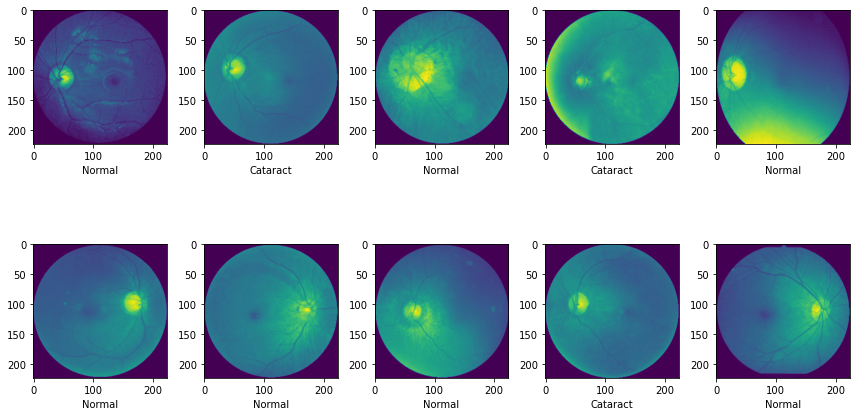

In [67]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(datasetGL)))
    image = datasetGL[sample][0]
    category = datasetGL[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout() 

In [71]:
x = np.array([i[0] for i in datasetGL]).reshape(-1,image_size,image_size)
y = np.array([i[1] for i in datasetGL])

In [72]:
print(x.shape)
print(y.shape)

(1113, 224, 224)
(1113,)


In [73]:
x = x.reshape((len(y), -1))

print(x.shape)

(1113, 50176)


In [75]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [76]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(890, 50176) (890,)
(223, 50176) (223,)


#Training

In [106]:
from sklearn import svm, metrics

from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier

In [107]:
# Create a classifier: a support vector classifier
classifier = svm.SVC(gamma=0.001)

In [108]:
# Now predict the value of test data:
start = time.time()
classifier.fit(x_train,y_train)
expected = y_test
predicted = classifier.predict(x_test)
print('Time to build classifier: {} mins'.format(round((time.time() - start) / 60, 2)))

Time to build classifier: 2.62 mins


In [109]:
print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(expected, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

Classification report for classifier SVC(gamma=0.001):
              precision    recall  f1-score   support

           0       0.78      1.00      0.88        98
           1       1.00      0.78      0.88       125

    accuracy                           0.88       223
   macro avg       0.89      0.89      0.88       223
weighted avg       0.91      0.88      0.88       223


Confusion matrix:
[[98  0]
 [27 98]]


In [110]:
knn = KNeighborsClassifier(5)

In [111]:
start = time.time()
knn.fit(x_train,y_train)

# Now predict the value of the digit on the second half:
expected = y_test
predicted = knn.predict(x_test)
print('Time to build knn: {} mins'.format(round((time.time() - start) / 60, 2)))

Time to build knn: 0.41 mins


In [112]:
print("Classification report for classifier %s:\n%s\n"
      % (knn, metrics.classification_report(expected, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

Classification report for classifier KNeighborsClassifier():
              precision    recall  f1-score   support

           0       0.61      0.68      0.64        98
           1       0.73      0.66      0.69       125

    accuracy                           0.67       223
   macro avg       0.67      0.67      0.67       223
weighted avg       0.67      0.67      0.67       223


Confusion matrix:
[[67 31]
 [43 82]]


In [113]:
rfc = RandomForestClassifier()

In [114]:
start = time.time()
rfc.fit(x_train,y_train)

# Now predict the value of the digit on the second half:
expected = y_test
predicted = rfc.predict(x_test)

print('Time to build rfc: {} mins'.format(round((time.time() - start) / 60, 2)))

Time to build rfc: 0.27 mins


In [115]:
print("Classification report for classifier %s:\n%s\n"
      % (rfc, metrics.classification_report(expected, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

Classification report for classifier RandomForestClassifier():
              precision    recall  f1-score   support

           0       0.84      0.76      0.80        98
           1       0.82      0.89      0.85       125

    accuracy                           0.83       223
   macro avg       0.83      0.82      0.82       223
weighted avg       0.83      0.83      0.83       223


Confusion matrix:
[[ 74  24]
 [ 14 111]]


In [116]:
print(x_test)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [119]:
type(x_test)

numpy.ndarray

In [120]:
! mkdir models

mkdir: cannot create directory ‘models’: File exists


In [124]:
#Saving the random forest model
#from sklearn.externals import joblib
#import sklearn.external.joblib as extjoblib
import joblib

start = time.time()
joblib_file = "models/rfc.pkl"  
joblib.dump(rfc, joblib_file)

print('Time to export rfc: {} mins'.format(round((time.time() - start) / 60, 2)))

Time to export rfc: 0.14 mins
